In [ ]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import sys

In [ ]:
# prompt: dapatkan versi dari tensorflow yang digunakan

tf.__version__


'2.17.1'

In [ ]:
print(f"Python version: {sys.version}")
print(f"Python version info: {sys.version_info}")

Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Python version info: sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)


In [ ]:
def parse_data_from_file():
  product_names = []
  labels = []

  with open('shuffled_data.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader)

    for row in reader:
      product_names.append(row[0])
      labels.append(row[1])

  return product_names, labels

In [ ]:
product_names, labels = parse_data_from_file()

print(f'length of product names: {len(product_names)}')
print(f'first product name: {product_names[0]}')
print(f'first product name has {len(product_names[0].split())} words')
print(f'length of labels: {len(labels)}')
print(f'daftar labels adalah {list(set(labels))}')

length of product names: 6482
first product name: Pantene Conditioner Tanpa Bilas Perfect On 40Ml
first product name has 7 words
length of labels: 6482
daftar labels adalah ['kecantikan', 'product-segar', 'makanan', 'kesehatan', 'minuman', 'home-living']


In [ ]:
def train_val_datasets():
  train_size = int(len(product_names) * 0.9)

  train_product_names = product_names[:train_size]
  train_labels = labels[:train_size]

  val_product_names = product_names[train_size:]
  val_labels = labels[train_size:]

  train_dataset = tf.data.Dataset.from_tensor_slices((train_product_names, train_labels))
  val_dataset = tf.data.Dataset.from_tensor_slices((val_product_names, val_labels))

  return train_dataset, val_dataset

In [ ]:
train_dataset, validation_dataset = train_val_datasets()

print(f"there are {train_dataset.cardinality()} product name - label pairs for training.\n")
print(f"there are {validation_dataset.cardinality()} product name - label pairs for validation.\n")

there are 5833 product name - label pairs for training.

there are 649 product name - label pairs for validation.



In [ ]:
@tf.keras.utils.register_keras_serializable()
def standardize_product_name(product_name):
  product_name = tf.strings.lower(product_name)
  product_name = tf.strings.regex_replace(
      product_name, r"\b\d+(\.\d+)?x\d+(\.\d+)?(g|ml|kg|lt)\b", ""
  )
  product_name = tf.strings.regex_replace(
      product_name, r"\b\d+(\.\d+)?(g|ml|kg|lt)\b", ""
  )
  product_name = tf.strings.regex_replace(product_name, r"\b\d+(g|ml|kg|lt)\b", "")
  product_name = tf.strings.regex_replace(product_name, r"\b\d+\'s\b", "")
  product_name = tf.strings.regex_replace(product_name, r"[^a-z\s]", "")
  product_name = tf.strings.regex_replace(product_name, r'\s{2,}', ' ')
  product_name = tf.strings.strip(product_name)

  return product_name

In [ ]:
import random

random_product_names = random.sample(product_names, 10)
for random_product_name in random_product_names:
  standardized_product_name = standardize_product_name(random_product_name)

  print(f'product name: {random_product_name}')
  print(f'standardized product name: {standardized_product_name}\n')

product name: Wardah Lightening Cleansing Milk 100ml
standardized product name: b'wardah lightening cleansing milk'

product name: Lee Kum Kee Pure Sesame Oil 115Ml
standardized product name: b'lee kum kee pure sesame oil'

product name: Cimory Yogurt Squeeze Purple Taro 120G
standardized product name: b'cimory yogurt squeeze purple taro'

product name: Poise Facial Foam Oil Control 100G
standardized product name: b'poise facial foam oil control'

product name: Darlie Pasta Gigi Double Action Original Mint 120g
standardized product name: b'darlie pasta gigi double action original mint'

product name: Majestyk Risol Medan Kota
standardized product name: b'majestyk risol medan kota'

product name: Ayam Ungkep Djogja Ayam Kampung Tulang Lunak Frozen 1 Ekor
standardized product name: b'ayam ungkep djogja ayam kampung tulang lunak frozen ekor'

product name: Indofood Bumbu Spesial Racik Kare 45G
standardized product name: b'indofood bumbu spesial racik kare'

product name: Citra Putri Tepun

In [ ]:
VOCAB_SIZE = 5000
EMBEDDING_DIM = 16
MAX_LENGTH = 120

In [ ]:
def fit_vectorizer(product_names):
  vectorizer = tf.keras.layers.TextVectorization(
      standardize=standardize_product_name,
      output_sequence_length=MAX_LENGTH,
      max_tokens=VOCAB_SIZE,
  )
  vectorizer.adapt(product_names)

  return vectorizer

In [ ]:
vectorizer = fit_vectorizer(train_dataset.map(lambda product_name, label: product_name))
vocab_size = vectorizer.vocabulary_size()

print(f"vocabulary contains {vocab_size} words\n")

vocabulary contains 4339 words



In [ ]:
def fit_encoder():
  train_labels = train_dataset.map(lambda product_name, label: label)
  validation_labels = validation_dataset.map(lambda product_name, label: label)
  labels = train_labels.concatenate(validation_labels)

  encoder = tf.keras.layers.StringLookup(
      # oov_token='<UNK>',
      num_oov_indices=0,
  )
  encoder.adapt(labels)

  return encoder

In [ ]:
encoder = fit_encoder()

print(f'unique labels: {encoder.get_vocabulary()}')

unique labels: ['makanan', 'kecantikan', 'home-living', 'minuman', 'product-segar', 'kesehatan']


In [ ]:
def preprocess_dataset(dataset, vectorizer, encoder):
  dataset = dataset.map(lambda product_name, label: (vectorizer(product_name), encoder(label)))
  dataset = dataset.batch(32)

  return dataset

In [ ]:
train_proc_dataset = preprocess_dataset(train_dataset, vectorizer, encoder)
validation_proc_dataset = preprocess_dataset(validation_dataset, vectorizer, encoder)

print(f"number of batches in the train dataset: {train_proc_dataset.cardinality()}")
print(f"number of batches in the validation dataset: {validation_proc_dataset.cardinality()}")

number of batches in the train dataset: 183
number of batches in the validation dataset: 21


In [ ]:
train_batch = next(train_proc_dataset.as_numpy_iterator())
validation_batch = next(validation_proc_dataset.as_numpy_iterator())

print(f"shape of the train batch: {train_batch[0].shape}")
print(f"shape of the validation batch: {validation_batch[0].shape}")

shape of the train batch: (32, 120)
shape of the validation batch: (32, 120)


In [ ]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        mask_zero=True,
    ),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
  ])

  model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
  )

  return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 120, 16)             │          80,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,478 (318.27 KB)

 Trainable params: 81,478 (318.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
example_batch = train_proc_dataset.take(1)

try:
  model.evaluate(example_batch, verbose=False)
except:
	print("your model is not compatible with the dataset you defined earlier. check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 6)


In [ ]:
history = model.fit(
    train_proc_dataset,
    epochs=50,
    validation_data=validation_proc_dataset,
)

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3964 - loss: 1.6451 - val_accuracy: 0.7134 - val_loss: 0.8229
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8198 - loss: 0.6358 - val_accuracy: 0.9245 - val_loss: 0.2950
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9277 - loss: 0.2425 - val_accuracy: 0.9522 - val_loss: 0.1802
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9617 - loss: 0.1329 - val_accuracy: 0.9615 - val_loss: 0.1386
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9696 - loss: 0.0884 - val_accuracy: 0.9599 - val_loss: 0.1223
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9713 - loss: 0.0688 - val_accuracy: 0.9599 - val_loss: 0.1156
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9713 - loss: 0.0591 - val_accuracy: 0.9584 - val_loss: 0.1130
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9713 - loss: 0.0539 - val_accuracy:

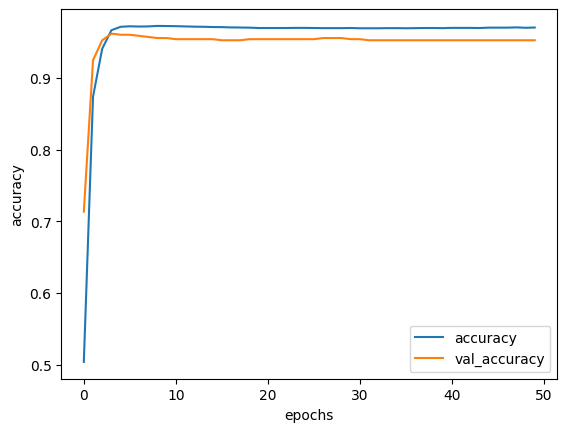

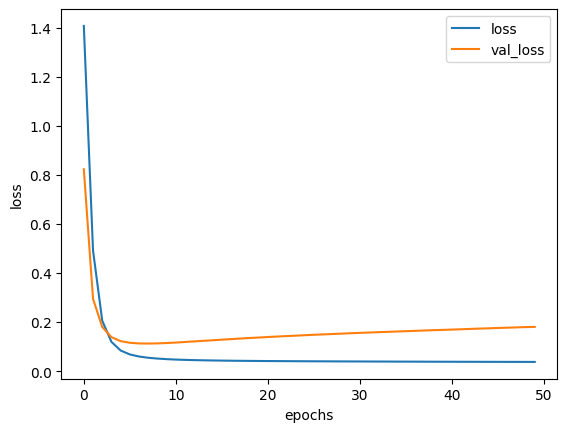

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history[f'val_{metric}'])
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend([metric, f'val_{metric}'])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# export model
import pickle

if not os.path.exists(os.path.join('model')):
  os.mkdir(os.path.join('model'))

model.save(os.path.join('model', 'model.keras'))

with open(os.path.join('model', 'vectorizer.pickle'), 'wb') as f:
  pickle.dump(vectorizer, f)

with open(os.path.join('model', 'encoder.pickle'), 'wb') as f:
  pickle.dump(encoder, f)

In [ ]:
!zip -r /content/product-classification-model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/vectorizer.pickle (deflated 74%)
  adding: content/model/encoder.pickle (deflated 74%)
  adding: content/model/model.keras (deflated 19%)
